In [1]:
!pip install torch==2.3.0 torchvision==0.15.2 albumentations==1.4.11 pandas==2.2.2 opencv-python==4.10.0.84 matplotlib==3.9.0 scikit-learn==1.5.0

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==2.3.0 and torchvision==0.15.2 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==2.3.0
    torchvision 0.15.2 depends on torch==2.0.1

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

In [3]:
import warnings
warnings.filterwarnings("ignore")

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla P100-PCIE-16GB


In [4]:
benign_dir = "/kaggle/input/iaaa-mri-train-data-partition/iaaa-mri-train-data partition/data/benign"
malignant_dir = "/kaggle/input/iaaa-mri-train-data-partition/iaaa-mri-train-data partition/data/malignant"

def get_file_paths(directory):
    return [os.path.join(dirpath, f) for dirpath, _, filenames in os.walk(directory) for f in filenames if f.endswith('.jpg')]

benign_files = get_file_paths(benign_dir)
malignant_files = get_file_paths(malignant_dir)

print(f"Number of benign files: {len(benign_files)}")
print(f"Number of malignant files: {len(malignant_files)}")

if len(benign_files) == 0 or len(malignant_files) == 0:
    raise ValueError("No image files found in one or both directories. Please check the file paths.")

data = {
    "image_path": benign_files + malignant_files,
    "label": [0] * len(benign_files) + [1] * len(malignant_files)
}

df = pd.DataFrame(data)

print(f"Total number of samples: {len(df)}")

if len(df) > 1:
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    image_paths_resampled, labels_resampled = rus.fit_resample(df[['image_path']], df['label'])

    df_resampled = pd.DataFrame({'image_path': image_paths_resampled.iloc[:, 0], 'label': labels_resampled})
    df_resampled = df_resampled.sample(frac=1).reset_index(drop=True)

    print(f"Number of samples after resampling: {len(df_resampled)}")

    train_df, temp_df = train_test_split(df_resampled, test_size=0.3, stratify=df_resampled['label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'])
else:
    raise ValueError("Not enough samples to perform resampling and splitting.")

class BrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0], cv2.IMREAD_GRAYSCALE)
        image = np.array(image)
        label = self.df.iloc[idx, 1]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        image = image.repeat(3, 1, 1)
        image = image.float() / 255.0
        label = torch.tensor(label, dtype=torch.float32)

        return image, label

train_transform = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True),
    A.Resize(160, 160),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.5),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.5),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True),
    A.Resize(160, 160),
    ToTensorV2(),
])

def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))

            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, scaler, patience=5):
    best_val_acc = 0.0
    no_improve_epochs = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step(val_acc)
        
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Current Learning Rate: {current_lr:.6f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Best validation accuracy: {best_val_acc:.4f}")
    return history

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = BrainDataset(train_df, transform=train_transform)
val_dataset = BrainDataset(val_df, transform=val_transform)
test_dataset = BrainDataset(test_df, transform=val_transform)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model = models.efficientnet_b5(weights=models.EfficientNet_B5_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(model.classifier[1].in_features, 1)
)
model = model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

criterion = FocalLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
num_epochs = 40
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
scaler = GradScaler()

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, scaler)

model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Number of benign files: 45855
Number of malignant files: 6466
Total number of samples: 52321
Number of samples after resampling: 12932


Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 187MB/s]
Validating: 100%|██████████| 122/122 [00:16<00:00,  7.57it/s]


Epoch 1/40
Train Loss: 0.0437, Train Acc: 0.5019
Val Loss: 0.0417, Val Acc: 0.5010
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.85it/s]


Epoch 2/40
Train Loss: 0.0423, Train Acc: 0.5106
Val Loss: 0.0410, Val Acc: 0.5418
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 14.01it/s]


Epoch 3/40
Train Loss: 0.0413, Train Acc: 0.5219
Val Loss: 0.0422, Val Acc: 0.5082
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 14.07it/s]


Epoch 4/40
Train Loss: 0.0406, Train Acc: 0.5391
Val Loss: 0.0404, Val Acc: 0.5232
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.96it/s]


Epoch 5/40
Train Loss: 0.0400, Train Acc: 0.5513
Val Loss: 0.0400, Val Acc: 0.5814
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.88it/s]


Epoch 6/40
Train Loss: 0.0398, Train Acc: 0.5569
Val Loss: 0.0393, Val Acc: 0.5593
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:09<00:00, 13.43it/s]


Epoch 7/40
Train Loss: 0.0390, Train Acc: 0.5724
Val Loss: 0.0382, Val Acc: 0.5881
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 14.07it/s]


Epoch 8/40
Train Loss: 0.0384, Train Acc: 0.5763
Val Loss: 0.0383, Val Acc: 0.5778
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 14.13it/s]


Epoch 9/40
Train Loss: 0.0382, Train Acc: 0.5842
Val Loss: 0.0385, Val Acc: 0.5747
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 14.04it/s]


Epoch 10/40
Train Loss: 0.0377, Train Acc: 0.5946
Val Loss: 0.0381, Val Acc: 0.5907
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.95it/s]


Epoch 11/40
Train Loss: 0.0373, Train Acc: 0.5998
Val Loss: 0.0381, Val Acc: 0.5902
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 14.12it/s]


Epoch 12/40
Train Loss: 0.0370, Train Acc: 0.6048
Val Loss: 0.0391, Val Acc: 0.6206
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.92it/s]


Epoch 13/40
Train Loss: 0.0365, Train Acc: 0.6093
Val Loss: 0.0399, Val Acc: 0.6253
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.68it/s]


Epoch 14/40
Train Loss: 0.0360, Train Acc: 0.6201
Val Loss: 0.0382, Val Acc: 0.6057
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.60it/s]


Epoch 15/40
Train Loss: 0.0360, Train Acc: 0.6180
Val Loss: 0.0369, Val Acc: 0.6186
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.86it/s]


Epoch 16/40
Train Loss: 0.0353, Train Acc: 0.6319
Val Loss: 0.0369, Val Acc: 0.6000
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 14.09it/s]


Epoch 17/40
Train Loss: 0.0347, Train Acc: 0.6373
Val Loss: 0.0367, Val Acc: 0.6304
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:09<00:00, 12.52it/s]


Epoch 18/40
Train Loss: 0.0344, Train Acc: 0.6455
Val Loss: 0.0369, Val Acc: 0.6237
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:09<00:00, 12.55it/s]


Epoch 19/40
Train Loss: 0.0342, Train Acc: 0.6491
Val Loss: 0.0373, Val Acc: 0.6366
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:09<00:00, 12.43it/s]


Epoch 20/40
Train Loss: 0.0338, Train Acc: 0.6526
Val Loss: 0.0492, Val Acc: 0.6402
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:09<00:00, 12.50it/s]


Epoch 21/40
Train Loss: 0.0332, Train Acc: 0.6570
Val Loss: 0.0425, Val Acc: 0.6258
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 14.00it/s]


Epoch 22/40
Train Loss: 0.0326, Train Acc: 0.6671
Val Loss: 0.0388, Val Acc: 0.6794
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.80it/s]


Epoch 23/40
Train Loss: 0.0327, Train Acc: 0.6668
Val Loss: 0.0390, Val Acc: 0.6160
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:08<00:00, 14.34it/s]


Epoch 24/40
Train Loss: 0.0321, Train Acc: 0.6814
Val Loss: 0.0374, Val Acc: 0.6613
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:09<00:00, 13.49it/s]


Epoch 25/40
Train Loss: 0.0320, Train Acc: 0.6804
Val Loss: 0.0386, Val Acc: 0.6314
Current Learning Rate: 0.000100


Validating: 100%|██████████| 122/122 [00:09<00:00, 13.54it/s]


Epoch 26/40
Train Loss: 0.0308, Train Acc: 0.6993
Val Loss: 0.0378, Val Acc: 0.6284
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.88it/s]


Epoch 27/40
Train Loss: 0.0289, Train Acc: 0.7058
Val Loss: 0.0365, Val Acc: 0.6918
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:09<00:00, 12.41it/s]


Epoch 28/40
Train Loss: 0.0277, Train Acc: 0.7254
Val Loss: 0.0384, Val Acc: 0.6943
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:09<00:00, 13.36it/s]


Epoch 29/40
Train Loss: 0.0277, Train Acc: 0.7269
Val Loss: 0.0380, Val Acc: 0.6959
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.82it/s]


Epoch 30/40
Train Loss: 0.0268, Train Acc: 0.7402
Val Loss: 0.0383, Val Acc: 0.6954
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.95it/s]


Epoch 31/40
Train Loss: 0.0271, Train Acc: 0.7412
Val Loss: 0.0385, Val Acc: 0.7026
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:09<00:00, 12.84it/s]


Epoch 32/40
Train Loss: 0.0257, Train Acc: 0.7554
Val Loss: 0.0400, Val Acc: 0.6938
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:09<00:00, 12.39it/s]


Epoch 33/40
Train Loss: 0.0262, Train Acc: 0.7501
Val Loss: 0.0399, Val Acc: 0.7052
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:08<00:00, 14.10it/s]


Epoch 34/40
Train Loss: 0.0256, Train Acc: 0.7591
Val Loss: 0.0396, Val Acc: 0.7082
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:08<00:00, 14.30it/s]


Epoch 35/40
Train Loss: 0.0255, Train Acc: 0.7582
Val Loss: 0.0408, Val Acc: 0.7021
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:08<00:00, 14.15it/s]


Epoch 36/40
Train Loss: 0.0256, Train Acc: 0.7568
Val Loss: 0.0400, Val Acc: 0.7052
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:09<00:00, 12.56it/s]


Epoch 37/40
Train Loss: 0.0252, Train Acc: 0.7646
Val Loss: 0.0407, Val Acc: 0.7103
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.78it/s]


Epoch 38/40
Train Loss: 0.0247, Train Acc: 0.7651
Val Loss: 0.0421, Val Acc: 0.7160
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.90it/s]


Epoch 39/40
Train Loss: 0.0246, Train Acc: 0.7691
Val Loss: 0.0414, Val Acc: 0.7057
Current Learning Rate: 0.000010


Validating: 100%|██████████| 122/122 [00:08<00:00, 13.59it/s]


Epoch 40/40
Train Loss: 0.0248, Train Acc: 0.7670
Val Loss: 0.0403, Val Acc: 0.7088
Current Learning Rate: 0.000010
Best validation accuracy: 0.7160


Validating: 100%|██████████| 122/122 [00:16<00:00,  7.32it/s]

Test Loss: 0.0431, Test Acc: 0.7196


AUC for 50 random images: 0.8000


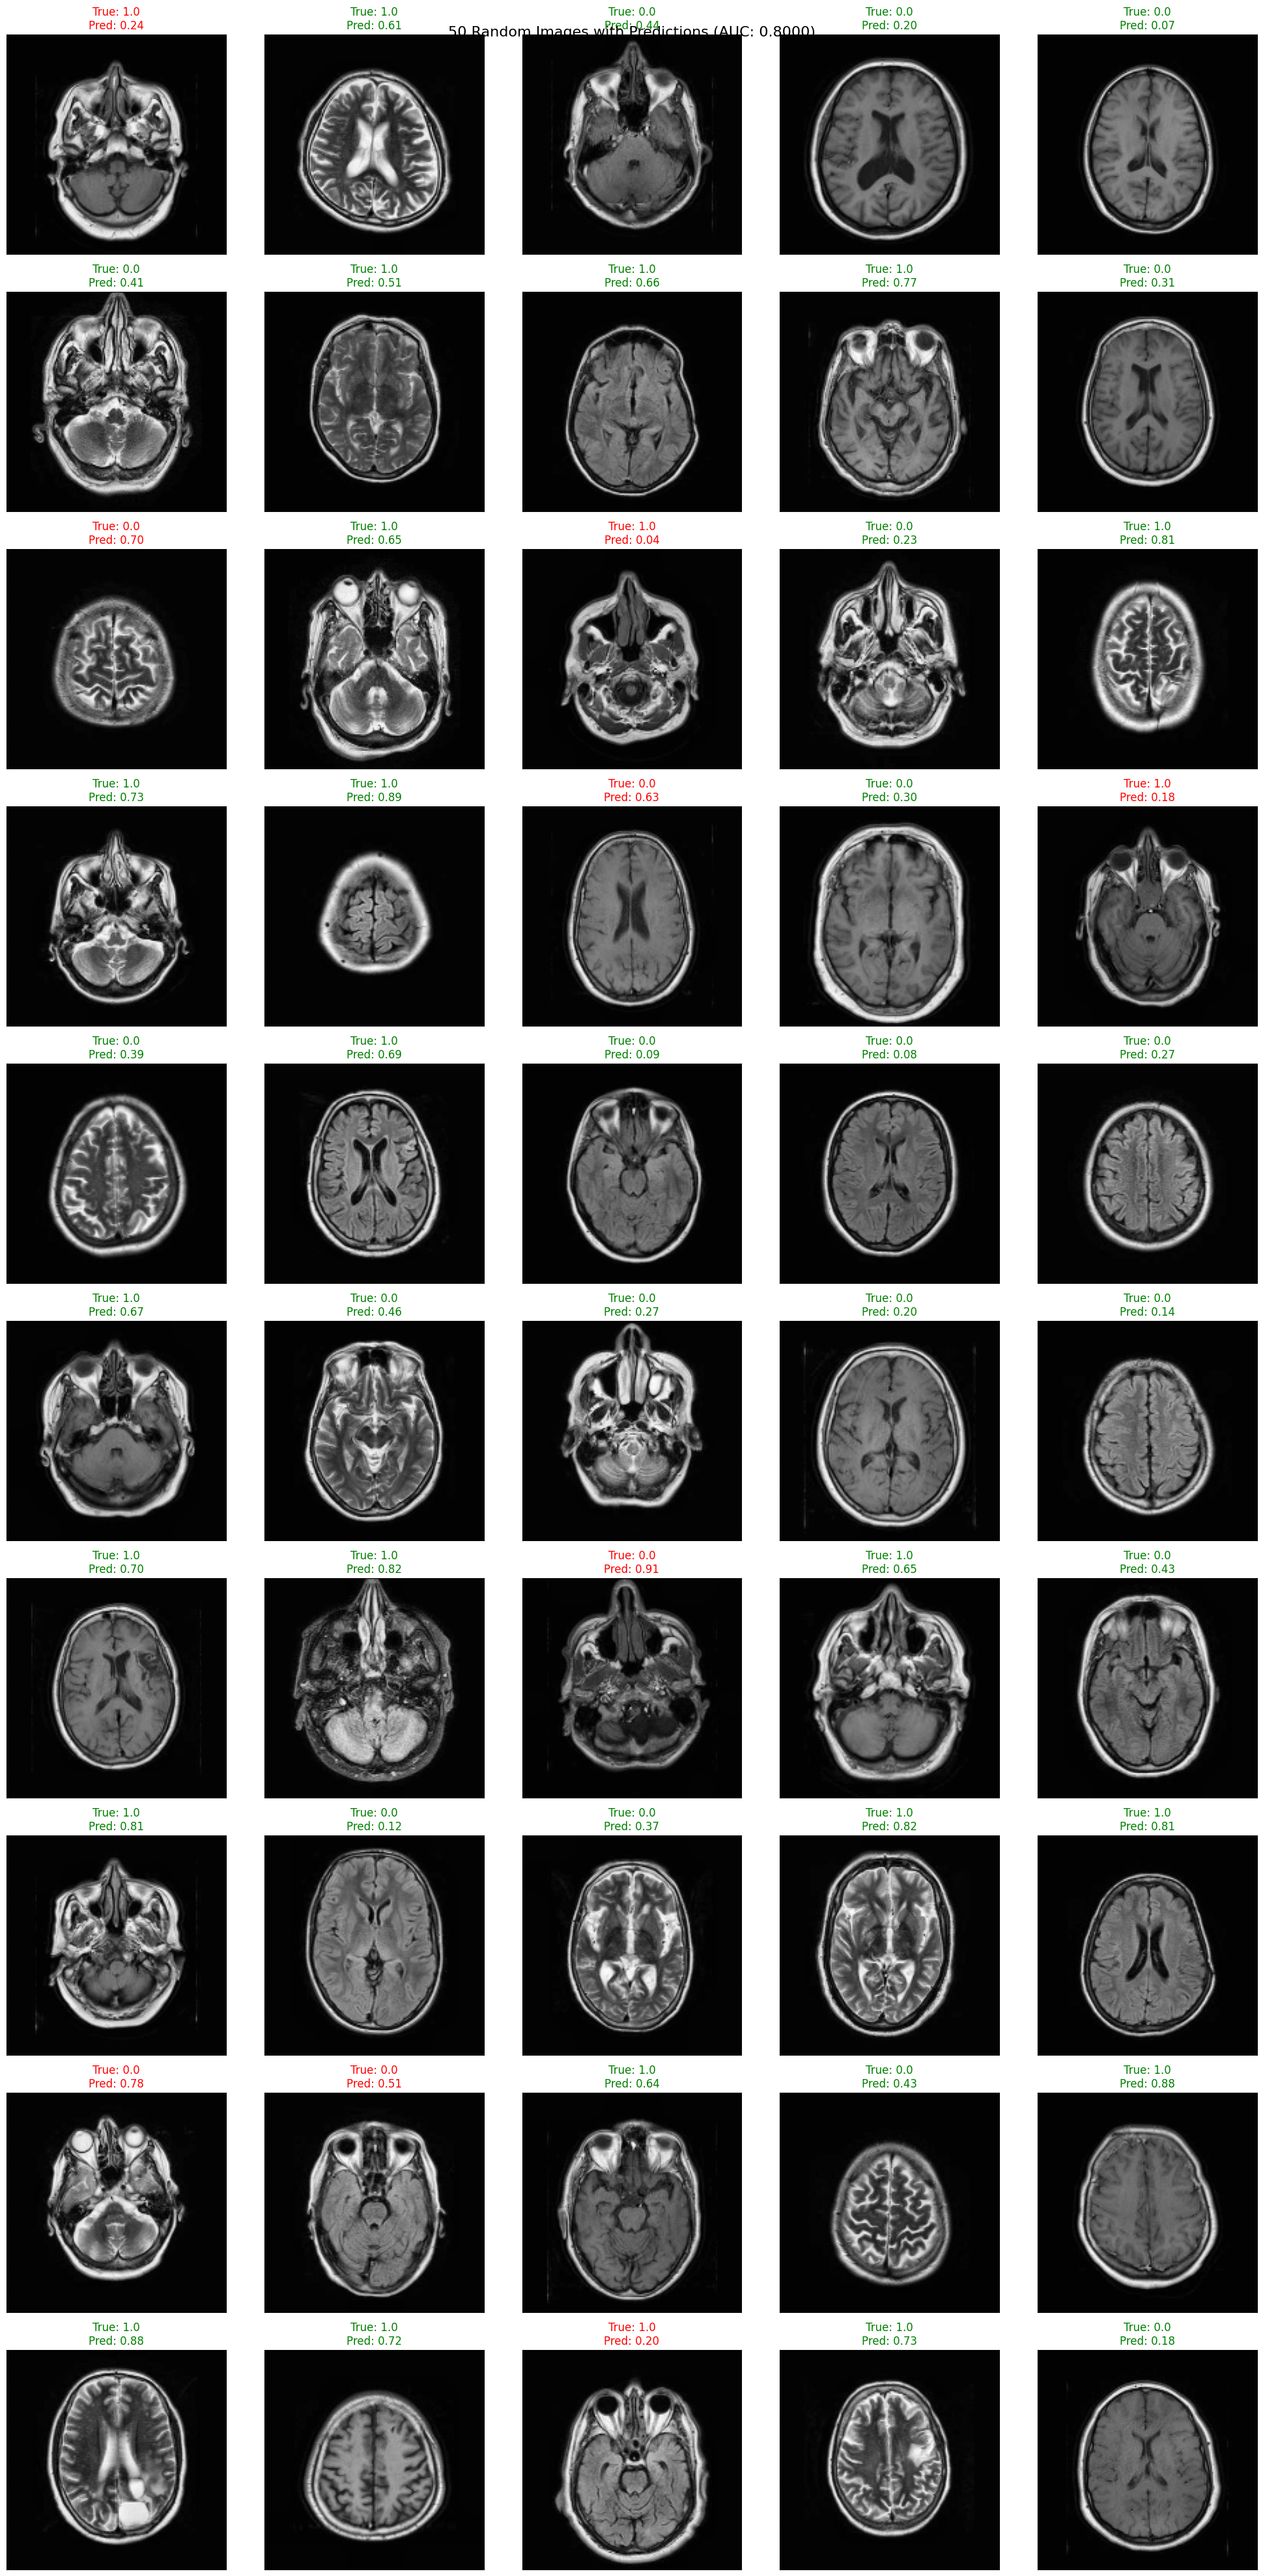

In [5]:
import random
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()

random_indices = random.sample(range(len(test_dataset)), 50)

random_loader = DataLoader([test_dataset[i] for i in random_indices], batch_size=1, shuffle=False)

predictions = []
true_labels = []
images = []

with torch.no_grad():
    for image, label in random_loader:
        image = image.to(device)
        output = model(image)
        pred = torch.sigmoid(output).cpu().numpy()[0][0]
        predictions.append(pred)
        true_labels.append(label.item())
        images.append(image.cpu().squeeze().permute(1, 2, 0).numpy())

auc = roc_auc_score(true_labels, predictions)
print(f"AUC for 50 random images: {auc:.4f}")

fig, axes = plt.subplots(10, 5, figsize=(20, 40))
fig.suptitle(f"50 Random Images with Predictions (AUC: {auc:.4f})", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i])
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        title = f"True: {true_labels[i]}\nPred: {predictions[i]:.2f}"
        ax.set_title(title, color='green' if (predictions[i] > 0.5) == true_labels[i] else 'red')

plt.tight_layout()
plt.show()